### Import libraries

In [98]:
# %load Kaggle - Zomato_combined.py
#!/usr/bin/env python

import os
import warnings
warnings.filterwarnings('ignore')
os.chdir('/Users/gosc/Desktop/Kaggle/Zomato - Bangalore') 


### data analysis
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

### text processing
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import operator

#### geolocation
import geopy
from geopy import geocoders
from geopy.geocoders import Nominatim

# lib for pandas profiling
import pandas_profiling
pd.options.display.max_columns = 30


### Read Data

In [99]:
data=pd.read_csv('zomato.csv',encoding='latin-1')
print('Data size is:')
print(len(data))
#data.head(5)

Data size is:
51717


### Data understanding

#### Duplications

In [100]:
DataFull=data.copy()  # dataset copied with purpose of 'listed analysis'
DuplicatedRows = data[data.duplicated(subset=['name','address'])]
print("Dups count:", len(DuplicatedRows))
#DuplicatedRows.head(20)

Dups count: 39218


In [101]:
data= data.drop_duplicates(subset=['name','address'],keep='first') #assumption of distinct identifier

In [102]:
### Overview - example
#print("Initial data set example:")
#DataFull[DataFull['name']=='Onesta']
#DuplicatedRows[DuplicatedRows['name']=='Onesta']
#len(data) -12.5 K

In [103]:
#print("Filtered dataset exampe:")
#data[data['name']=='Onesta']

In [104]:
len(data)

12499

#### Data Types

In [105]:
for col in data.columns:
    dtype = str(data[col].dtype)
    print(col, dtype)

url object
address object
name object
online_order object
book_table object
rate object
votes int64
phone object
location object
rest_type object
dish_liked object
cuisines object
approx_cost(for two people) object
reviews_list object
menu_item object
listed_in(type) object
listed_in(city) object


##### Number of Nulls


In [106]:
print('Number of nulls:')
round((data.isnull() | data.isna()).sum()/len(data),3)
#data[(data.menu_item.notnull()) & ~(data.menu_item.isna())]

Number of nulls:


url                            0.000
address                        0.000
name                           0.000
online_order                   0.000
book_table                     0.000
rate                           0.192
votes                          0.000
phone                          0.021
location                       0.001
rest_type                      0.005
dish_liked                     0.631
cuisines                       0.002
approx_cost(for two people)    0.005
reviews_list                   0.000
menu_item                      0.000
listed_in(type)                0.000
listed_in(city)                0.000
dtype: float64

##### Number of Unique Values

In [107]:
print('Number of unique values in the data')
print(data.nunique()) # maybe we still have some dups around 1 K but I am leaving like this
# Generate data report using pandas profile analysis
#profile = data.profile_report(title='Zomato profile analysis report')
#profile.to_file(output_file="zomato data analysis.html")

Number of unique values in the data
url                            12499
address                        11495
name                            8792
online_order                       2
book_table                         2
rate                              61
votes                           1242
phone                          10898
location                          93
rest_type                         93
dish_liked                      4277
cuisines                        2609
approx_cost(for two people)       70
reviews_list                    9966
menu_item                       2279
listed_in(type)                    7
listed_in(city)                   30
dtype: int64


### Data Preprocessing

##### Dropping some columns

In [108]:
data.drop(['url','phone'],inplace=True,axis=1)
DataFull.drop(['url','phone'],inplace=True,axis=1)

In [109]:
data.columns.values

array(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'], dtype=object)

In [110]:
DataFull.columns.values

array(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'], dtype=object)

##### Renaming columns

In [111]:
data.rename(columns=
        {'name':'rest_name','approx_cost(for two people)': 'meal_cost', 'listed_in(city)':
         'Neighbourhood','listed_in(type)':'restaurant_type','rest_type':'restaurant_category'}, inplace=True)
data.columns.values

array(['address', 'rest_name', 'online_order', 'book_table', 'rate',
       'votes', 'location', 'restaurant_category', 'dish_liked',
       'cuisines', 'meal_cost', 'reviews_list', 'menu_item',
       'restaurant_type', 'Neighbourhood'], dtype=object)

In [112]:
DataFull.rename(columns=
        {'name':'rest_name','approx_cost(for two people)': 'meal_cost', 'listed_in(city)':
         'listed_city','listed_in(type)':'restaurant_type','rest_type':'restaurant_category'}, inplace=True)
DataFull.columns.values

array(['address', 'rest_name', 'online_order', 'book_table', 'rate',
       'votes', 'location', 'restaurant_category', 'dish_liked',
       'cuisines', 'meal_cost', 'reviews_list', 'menu_item',
       'restaurant_type', 'listed_city'], dtype=object)

In [113]:
#np.mean(data.rate)

##### Preprocessing 

In [114]:
def preprocessing(data=data):
    data.rate = data.rate.astype(str).apply(lambda x: x.replace('/5',''))
    data.rate = data.rate.astype(str).apply(lambda x: x.replace(',/n',''))
    data.loc[(data.rate =='NEW') | (data.rate =='-'), 'rate'] = np.nan
    data.rate = data.rate.apply(lambda x: float(x))
    #data.rate = data.rate.replace(np.nan, np.mean(data.rate))
    data['meal_cost'] = data['meal_cost'].str.replace(',', '').astype(float)
    data['votes'] = data['votes'].astype(float)
    data['rest_name'] = data['rest_name'].str.strip()
    data['rest_name'] = data['rest_name'].replace(['[^A-Za-z0-9_.,!"\s]+'], [''], regex=True)

In [115]:
preprocessing(data=data)

In [116]:
preprocessing(data=DataFull)

In [117]:
'''for col in data.columns:
    dtype = str(data[col].dtype)
    print(col, dtype)'''

'for col in data.columns:\n    dtype = str(data[col].dtype)\n    print(col, dtype)'

### Variable enginering

##### Dish liked

In [118]:
# #May be number of dishesh liked 
# There is a mistake as nan has been counted as one
# #All the dishes liked are distinct and unique.
data['num_dishes_liked'] = data['dish_liked'].astype('str').apply(lambda x: len(x.split(',') if x!=np.nan else 0))

##### Dummy cuisine variable

In [119]:
z =[]
for i in data['cuisines'].astype('str').apply(lambda x: x.split(',')):
    for j in i:
        z.append(j.strip())
cusine_dict = Counter(z)  # create a dictionary based on values in list


cusine_dict=sorted(cusine_dict.items(), key=lambda x: x[1], reverse=True) # sort dictonary based on values of dictionary

# # Create boolean variables with cuisine type

#List for all the categories created
cuisine_type=['north indian','chinese','south indian','continental','cafe','fast food','beverages','italian','american','desserts']


data['cuisines']=data['cuisines'].astype('str').apply(lambda x: x.lower())# #Convert all the cuisine types into lower charatcers
data['cuisines']=data['cuisines'].astype('str').apply(lambda x: x.strip())# #Remove all the leading and trailing spaces from strings


# #replace all the categories which can be converted into meaningful categories - This categories have been created based on knowledge of food

data['cuisines_replaced']=data['cuisines'].replace({'pizza':'italian','bakery':'cafe','coffee':'cafe','ice cream':'desserts',
                                                   'street food':'fast food', 'andhra':'south indian', 'kerala':'south indian',
                                                   'biryani':'south indian', 'mughlai':'north indian', 'bihari':'north indian',
                                                   'rajasthani':'north indian', 'bengali':'north indian', 'bengali':'north indian',
                                                   'rajasthani':'north indian', 'salad':'continental', 'juices':'beverages',
                                                   'mithai':'desserts', 'mangalorean':'south indian', 'burger':'american','sandwich':'american',
                                                   'eastasian':'chinese','east asian':'thai','east asian':'asian', 'east asian':'pan asian'}, regex= True)



In [120]:
###Create dummy variables based on each string in variables cuisines.

temp=data.cuisines_replaced.str.get_dummies(sep=', ')


# #Create list of cuisines which are not part of cuisines category created.
# #We consider category which is not part of cuisine_type is rest_cuisines.

not_in_list = [col for col in temp.columns if col not in cuisine_type]
temp['rest_cusines']= temp[not_in_list].max(1)
cuisine_type.append('rest_cusines') # append list with rest_cuisine category
##reindex the dataframe temp with only categories we want from cuisine_type

temp= temp.reindex(cuisine_type, axis=1, fill_value=0)

# #concat the dataframes to get a single dataframe

data= pd.concat((data, temp), axis=1)

In [121]:
#data

,address,rest_name,online_order,book_table,rate,votes,location,restaurant_category,dish_liked,cuisines,meal_cost,reviews_list,menu_item,restaurant_type,Neighbourhood,num_dishes_liked,cuisines_replaced,north indian,chinese,south indian,continental,cafe,fast food,beverages,italian,american,desserts,rest_cusines
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","north indian, mughlai, chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,7,"north indian, north indian, chinese",1,1,0,0,0,0,0,0,0,0,0
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","chinese, north indian, thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,7,"chinese, north indian, thai",1,1,0,0,0,0,0,0,0,0,1
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","cafe, mexican, italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,7,"cafe, mexican, italian",0,0,0,0,1,0,0,1,0,0,1
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88.0,Banashankari,Quick Bites,Masala Dosa,"south indian, north indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,1,"south indian, north indian",1,0,1,0,0,0,0,0,0,0,0
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","north indian, rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,2,"north indian, north indian",1,0,0,0,0,0,0,0,0,0,0
5,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8,286.0,Basavanagudi,Casual Dining,"Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...",north indian,600.0,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari,7,north indian,1,0,0,0,0,0,0,0,0,0,0
6,"19/1, New Timberyard Layout, Beside Satellite ...",Rosewood International Hotel Bar Restaurant,No,No,3.6,8.0,Mysore Road,Casual Dining,NaN,"north indian, south indian, andhra, chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari,1,"north indian, south indian, south indian, chinese",1,1,1,0,0,0,0,0,0,0,0
7,"2469, 3rd Floor, 24th Cross, Opposite BDA Comp...",Onesta,Yes,Yes,4.6,2556.0,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","pizza, cafe, italian",600.0,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari,7,"italian, cafe, italian",0,0,0,0,1,0,0,1,0,0,0
8,"1, 30th Main Road, 3rd Stage, Banashankari, Ba...",Penthouse Cafe,Yes,No,4.0,324.0,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","cafe, italian, continental",700.0,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari,7,"cafe, italian, continental",0,0,0,1,1,0,0,1,0,0,0
9,"2470, 21 Main Road, 25th Cross, Banashankari, ...",Smacznego,Yes,No,4.2,504.0,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","cafe, mexican, italian, momos, beverages",550.0,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari,7,"cafe, mexican, italian, momos, beverages",0,0,0,0,1,0,1,1,0,0,1


##### Variable votes based on intervals

In [122]:
#data['votes_new']= pd.qcut(data['votes'],4, labels = False)
data['votes_new']= pd.qcut(data.votes.rank(method='first'), 4)
data['votes_new'].value_counts()
#data.drop(['votes'],axis=1, inplace = True)

(9374.5, 12499.0]    3125
(3125.5, 6250.0]     3125
(0.999, 3125.5]      3125
(6250.0, 9374.5]     3124
Name: votes_new, dtype: int64

In [123]:
DataFull.columns.values

array(['address', 'rest_name', 'online_order', 'book_table', 'rate',
       'votes', 'location', 'restaurant_category', 'dish_liked',
       'cuisines', 'meal_cost', 'reviews_list', 'menu_item',
       'restaurant_type', 'listed_city'], dtype=object)

In [97]:
.rename(columns=
        {'restaurant_type_x':'restaurant_type','restaurant_type_y': 'Type_List_Cnt', 'listed_city': 'City_List_Cnt'}, inplace=True)
data.columns.values

#### Listing count variable

In [124]:
dfg=DataFull.groupby(['rest_name','address']).nunique()

In [126]:
data = data.merge(dfg[['restaurant_type','listed_city']], how='inner', on=['rest_name', 'address'])

In [127]:
data.rename(columns=
        {'restaurant_type_x':'restaurant_type','restaurant_type_y': 'Type_List_Cnt', 'listed_city': 'City_List_Cnt'}, inplace=True)
data.columns.values

array(['address', 'rest_name', 'online_order', 'book_table', 'rate',
       'votes', 'location', 'restaurant_category', 'dish_liked',
       'cuisines', 'meal_cost', 'reviews_list', 'menu_item',
       'restaurant_type', 'Neighbourhood', 'num_dishes_liked',
       'cuisines_replaced', 'north indian', 'chinese', 'south indian',
       'continental', 'cafe', 'fast food', 'beverages', 'italian',
       'american', 'desserts', 'rest_cusines', 'votes_new',
       'Type_List_Cnt', 'City_List_Cnt'], dtype=object)

##### Just in case I remove neigbourhood and type listing from main data df (in order not to put noise in our clustering/prediction) bu i will leav ethem in DataFull for plotting

In [130]:
data.drop(['Neighbourhood','restaurant_type'],inplace=True,axis=1)

### EDA & Plotting

#### Color Map

In [165]:
color_map=['#FF9AA2','#FFDAC1', '#F1F0CF','#d6f8e9','#B5EAD7','#D3EEFF','#C1BBDD','#DCFFFB','#ADE6D0']
color_map2 = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

#### Plot definitions

In [166]:
def countplot(data, feature,limit=30, size=(16,4)):
    plt.figure(figsize=size)
    sns.countplot(data[feature], 
    palette='GnBu_d',order = data[feature].value_counts().head(limit).index)
    plt.title("Number of Observation per "+feature)
    plt.xticks(rotation=90)

In [167]:
def VotesCount(feature, limit=50, data=data, size=(12, 6)):
    group = data['votes'].groupby(data[feature])
    sum_vote = group.sum().sort_values(ascending=False)
    sum_vote.head(limit).plot(kind='bar', figsize=size, color='indianred', alpha=0.8);

In [168]:
def StackBarVotes(level_1, level_2, Agg, data=data, color=color_map, limit=25):
    group=data.groupby([level_1,level_2])
    g= group.sum()[Agg]
    g = g.unstack()
    g['sumval']=g.sum(axis = 1, skipna = True)
    g=g.sort_values('sumval', ascending=False).head(limit)
    g = g.drop(['sumval'], axis=1)
    g.plot(kind='bar', figsize=(10, 4), color=color, stacked=True)

In [169]:
def StackBarVotes2(level_1, level_2, Agg, perc=5, colors="tab20c"):
    group=data.groupby([level_1,level_2]).agg({Agg: ['sum']})
    g=group.reset_index()
    gperc = group.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    gpercf= gperc[gperc > perc].reset_index().dropna()
    gg = g.iloc[gpercf.index]
    k=gg.set_index([level_1, level_2]).sort_index(level=[level_1, level_2])
    ki=k.unstack()
    ki['sumval']=ki.sum(axis = 1, skipna = True)
    ki=ki.sort_values('sumval', ascending=False)
    ki = ki.drop(['sumval'], axis=1)
    ki.plot(kind='bar', figsize=(16, 10), cmap=colors, stacked=True)


In [170]:
def scatterplot(x, y, hue, data, h=13.7, w=10.27):
    sns.set(rc={'figure.figsize':((h,w))})
    sns.scatterplot(x=x, y=y, hue=hue,
                palette='Set3', data=data)

#### Number of records per feature

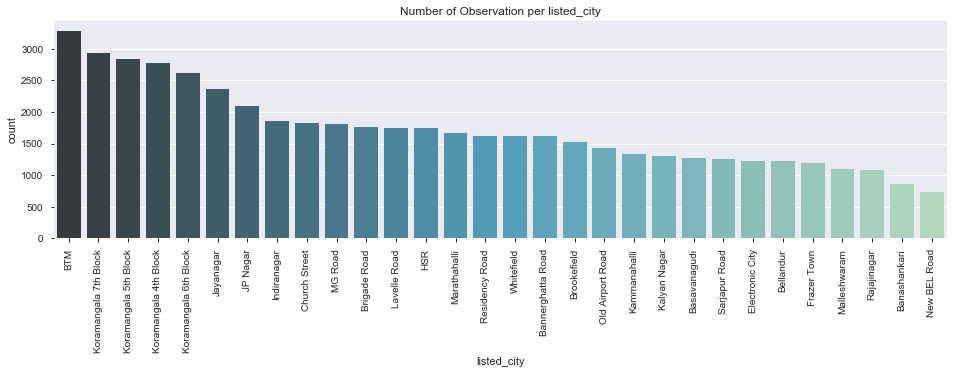

In [136]:
### Here more records than we have since some restaurants are assigned to more than one city
countplot(DataFull, 'listed_city')

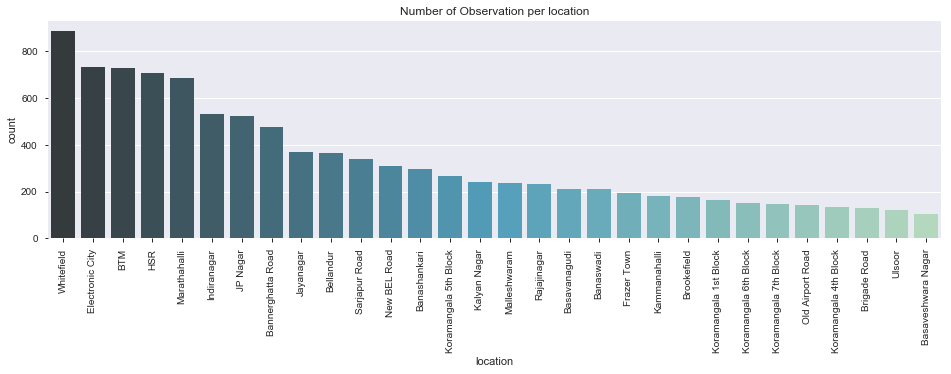

In [137]:
countplot(data, 'location')

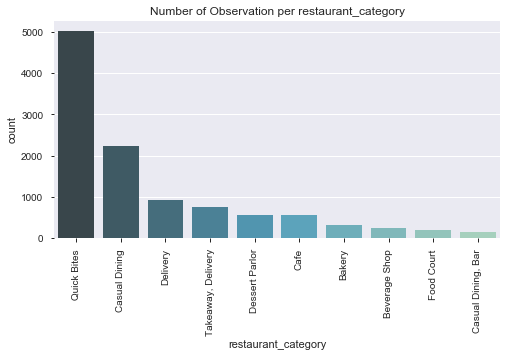

In [138]:
# 10 types of restaurants with the highest number of reviews
countplot(data, 'restaurant_category', 10, (8,4))

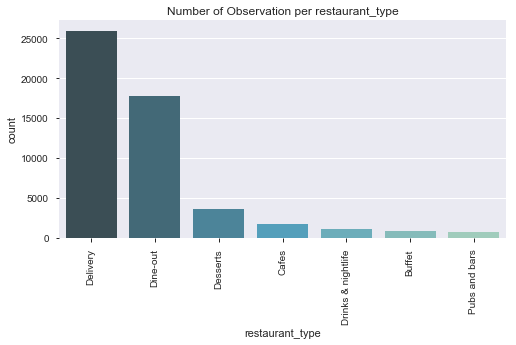

In [139]:
# Restaurants by Category 
countplot(DataFull, 'restaurant_type',10,(8,4)) ##same situaion - multiple types per rest possible

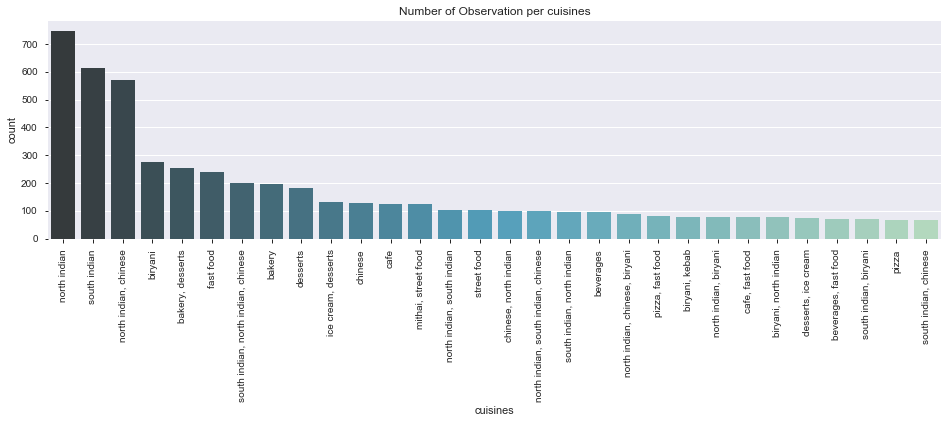

In [140]:
countplot(data, 'cuisines')

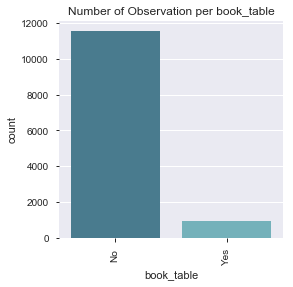

In [141]:
countplot(data, 'book_table',10,(4,4))

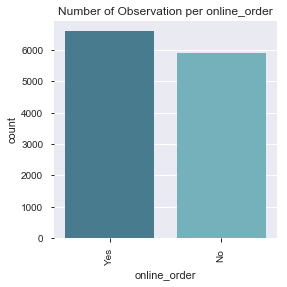

In [142]:
countplot(data, 'online_order',10,(4,4))

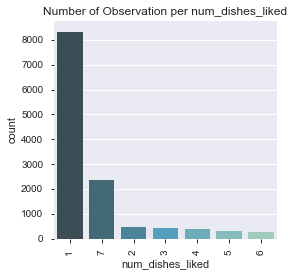

In [143]:
countplot(data, 'num_dishes_liked',10,(4,4))

#### New cusine plot ( dummy)

In [171]:
cuisine_new={}
list_cuisines=['north indian', 'chinese',
       'south indian', 'continental', 'cafe', 'fast food', 'beverages',
       'italian', 'american', 'desserts', 'rest_cusines']
for i in list_cuisines:
    #print(i, sum(data[i]))
    cuisine_new[i] = sum(data[i])

In [172]:
cuisine_new = sorted(cuisine_new.items(), key=operator.itemgetter(1), reverse=True)
cuisine_new = dict(cuisine_new)

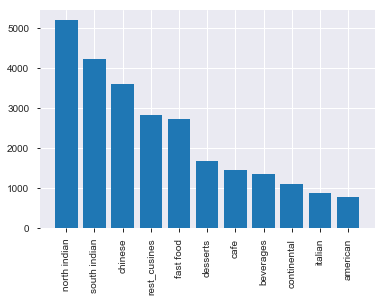

In [173]:
#plot
plt.bar(range(len(cuisine_new)), cuisine_new.values(), align='center')
plt.xticks(range(len(cuisine_new)), list(cuisine_new.keys()), rotation=90)

plt.show()

##### Number of Votes per feature

##### location

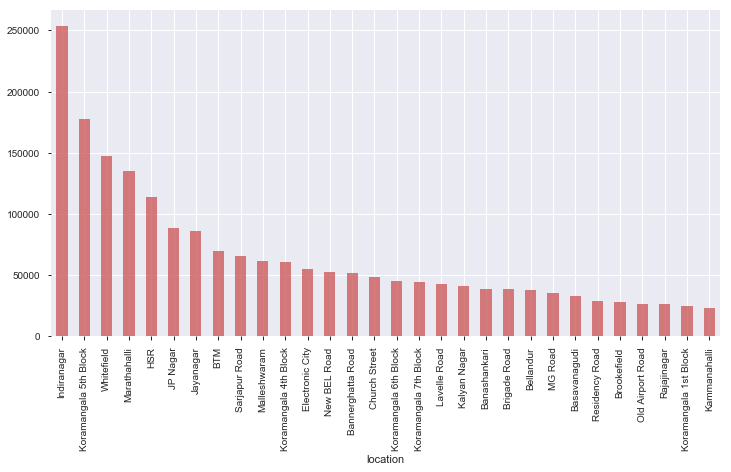

In [174]:
VotesCount('location', 30)

#### City Listed

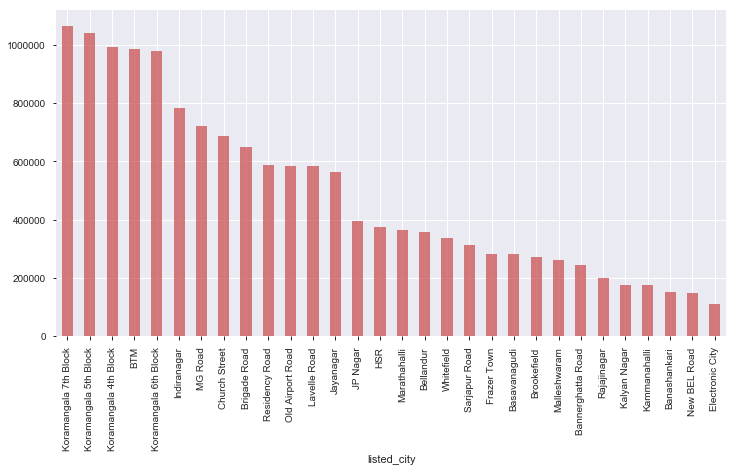

In [175]:
VotesCount('listed_city',data=DataFull)

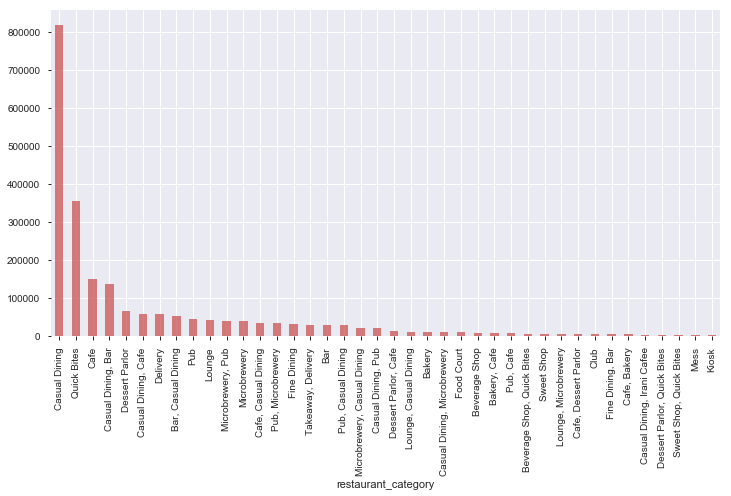

In [176]:
VotesCount('restaurant_category',40)

##### Restaurant Type

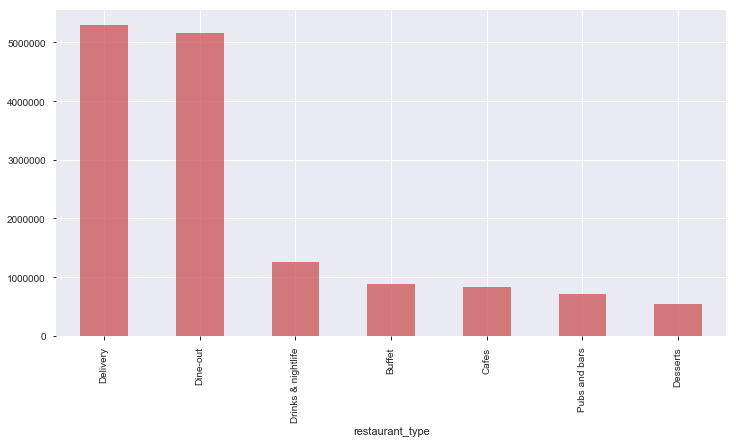

In [177]:
VotesCount('restaurant_type', 20, data=DataFull)

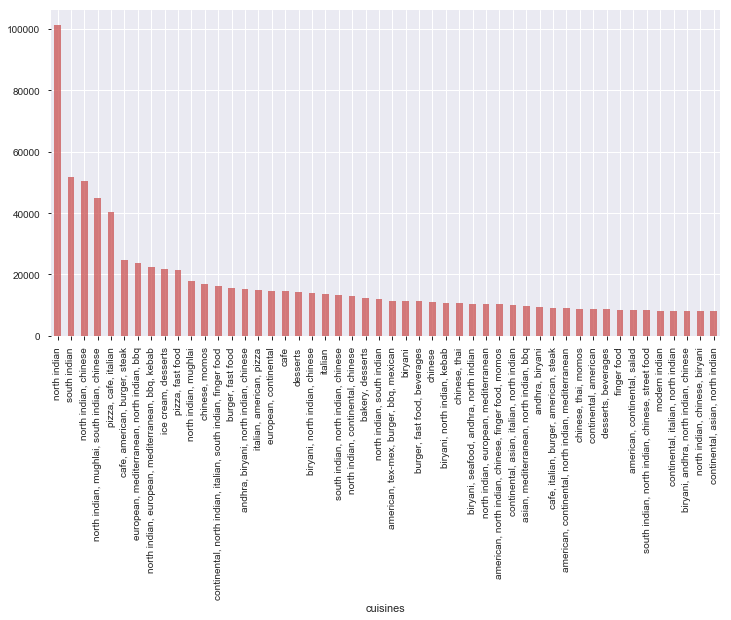

In [178]:
VotesCount('cuisines', data=data)

### New cusine votes and rates

In [179]:
cuisine_votes= {i: 0 for i in list_cuisines} 
cuisine_rate={i: 0 for i in list_cuisines}
CuisineRateVote=[]

for i in list_cuisines:
    n=0
    for index, row in data.dropna().iterrows():
        if row[i]==1:
            cuisine_votes[i] += row['votes'] #Number of votes
            cuisine_rate[i] += row['rate']
                #i changed previous code to change rate 'new' and '-' to 0 
                #-> but this actually increases denominator, and mean for such record are across whole ds
                #so it could over/underestimate -> so here exclude
            n +=1
    cuisine_rate[i]=round(cuisine_rate[i]/n,2) #avg rate
    CuisineRateVote.append([i, n, cuisine_rate[i], cuisine_votes[i]])
CuisineRateVoteDF=pd.DataFrame(CuisineRateVote)

In [180]:
CuisineRateVoteDF.columns = ['Cuisine', 'n','rate','votes']

In [181]:
CuisineRateVoteDF

,Cuisine,n,rate,votes
0,north indian,2051,3.76,1067889.0
1,chinese,1447,3.71,617430.0
2,south indian,1296,3.74,503731.0
3,continental,704,4.02,589669.0
4,cafe,603,3.95,302116.0
5,fast food,967,3.73,248910.0
6,beverages,491,3.93,171276.0
7,italian,593,3.95,433365.0
8,american,434,3.97,355828.0
9,desserts,593,4.01,189892.0


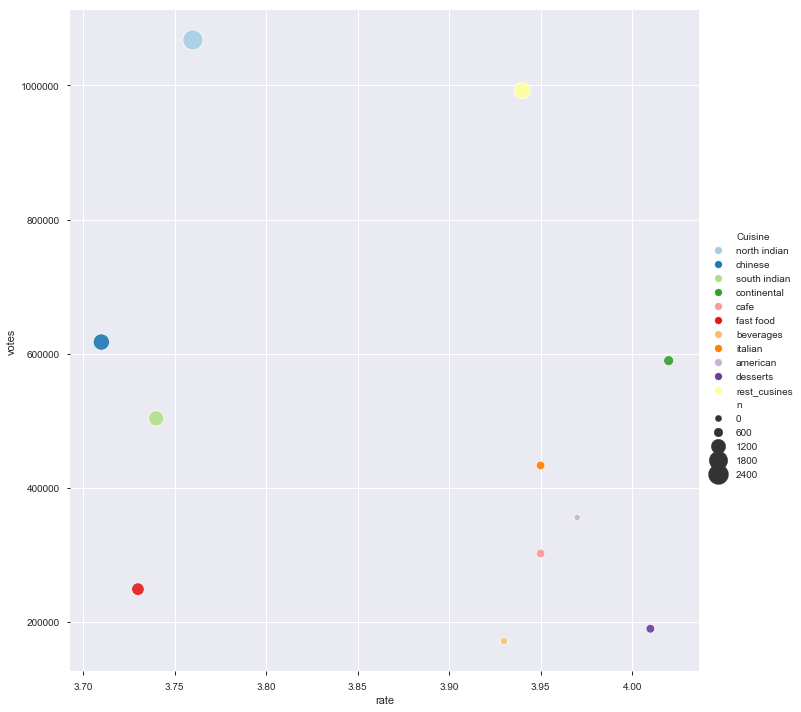

In [182]:
### Visualization
sns.relplot(x="rate", y="votes", hue="Cuisine", size="n",
            sizes=(40, 400), alpha=.9, palette="Paired",
            height=10, data=CuisineRateVoteDF)

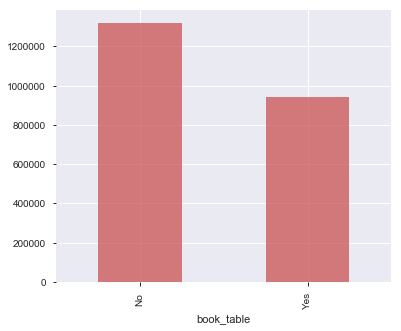

In [183]:
VotesCount('book_table', 2, data, (6, 5))

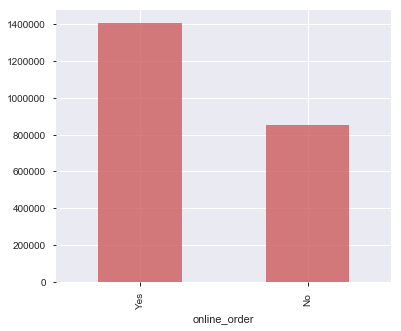

In [184]:
VotesCount('online_order', 2, data, (6, 5))

In [185]:
DataFull

,address,rest_name,online_order,book_table,rate,votes,location,restaurant_category,dish_liked,cuisines,meal_cost,reviews_list,menu_item,restaurant_type,listed_city
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775.0,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787.0,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918.0,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88.0,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166.0,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
5,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8,286.0,Basavanagudi,Casual Dining,"Onion Rings, Pasta, Kadhai Paneer, Salads, Sal...",North Indian,600.0,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari
6,"19/1, New Timberyard Layout, Beside Satellite ...",Rosewood International Hotel Bar Restaurant,No,No,3.6,8.0,Mysore Road,Casual Dining,NaN,"North Indian, South Indian, Andhra, Chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari
7,"2469, 3rd Floor, 24th Cross, Opposite BDA Comp...",Onesta,Yes,Yes,4.6,2556.0,Banashankari,"Casual Dining, Cafe","Farmhouse Pizza, Chocolate Banana, Virgin Moji...","Pizza, Cafe, Italian",600.0,"[('Rated 5.0', 'RATED\n I personally really l...",[],Cafes,Banashankari
8,"1, 30th Main Road, 3rd Stage, Banashankari, Ba...",Penthouse Cafe,Yes,No,4.0,324.0,Banashankari,Cafe,"Pizza, Mocktails, Coffee, Nachos, Salad, Pasta...","Cafe, Italian, Continental",700.0,"[('Rated 3.0', ""RATED\n I had been to this pl...",[],Cafes,Banashankari
9,"2470, 21 Main Road, 25th Cross, Banashankari, ...",Smacznego,Yes,No,4.2,504.0,Banashankari,Cafe,"Waffles, Pasta, Coleslaw Sandwich, Choco Waffl...","Cafe, Mexican, Italian, Momos, Beverages",550.0,"[('Rated 4.0', ""RATED\n Easy to locate\nVFM 3...",[],Cafes,Banashankari


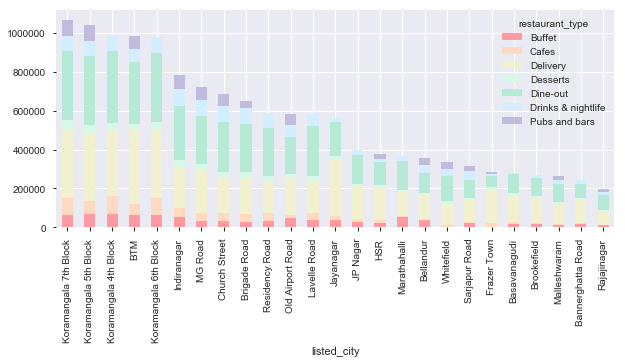

In [186]:
# #### Splitting cusine and restaurant category to visualisise
StackBarVotes('listed_city','restaurant_type','votes',data=DataFull)

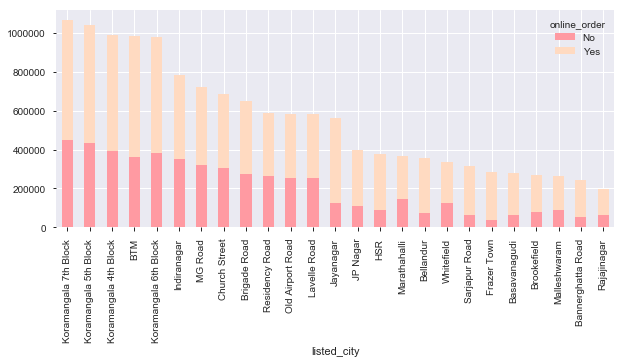

In [187]:
StackBarVotes('listed_city','online_order','votes',data=DataFull)

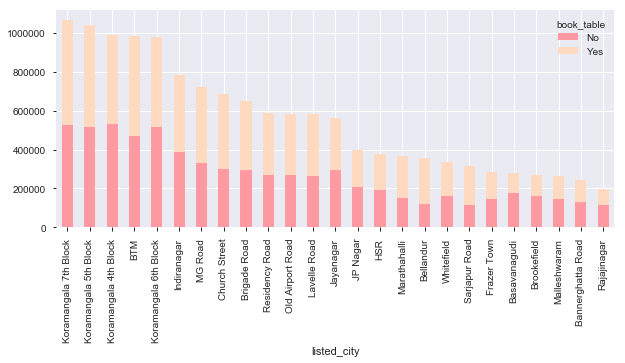

In [188]:
StackBarVotes('listed_city','book_table','votes',data=DataFull)

### Not finished 

In [189]:
'''
# Here I was trying to create sth that cuts groups with less than 5% numver of observation in each 
StackBarVotes2('Neighbourhood','restaurant_category','votes')




# 
# This below does not make any sense cause we missing biggest neigbourhoods because of divison

#StackBarVotes2('Neighbourhood','cuisines','votes',5,colors="tab20b")
#requires fixing wrong labels - sth to do with indexing


#proof
group=data.groupby(['Neighbourhood','cuisines']).agg({'votes': ['sum']})
g=group.reset_index()
gperc = group.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
gpercf= gperc[gperc > 5].reset_index().dropna()
#gpercf
'''

'\n# Here I was trying to create sth that cuts groups with less than 5% numver of observation in each \nStackBarVotes2(\'Neighbourhood\',\'restaurant_category\',\'votes\')\n\n\n\n\n# \n# This below does not make any sense cause we missing biggest neigbourhoods because of divison\n\n#StackBarVotes2(\'Neighbourhood\',\'cuisines\',\'votes\',5,colors="tab20b")\n#requires fixing wrong labels - sth to do with indexing\n\n\n#proof\ngroup=data.groupby([\'Neighbourhood\',\'cuisines\']).agg({\'votes\': [\'sum\']})\ng=group.reset_index()\ngperc = group.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))\ngpercf= gperc[gperc > 5].reset_index().dropna()\n#gpercf\n'

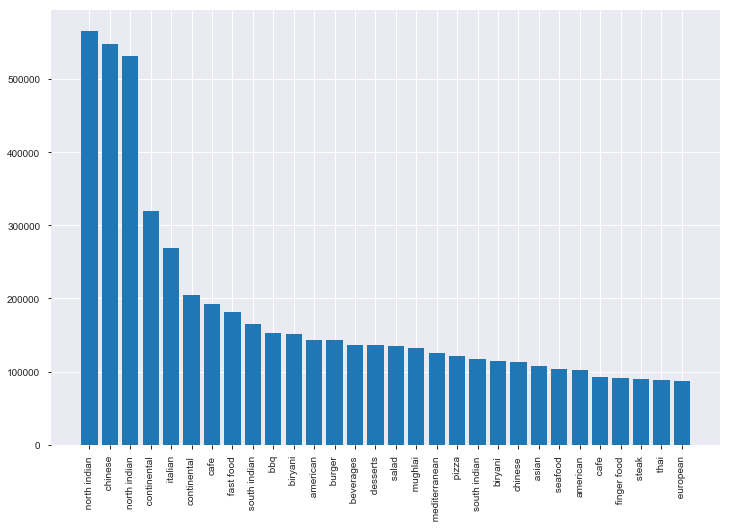

In [190]:
# #### Cusinine Dict
# 
# I have decided to manipulate with this feature to represent more accurately.

cuisine_list={}
for index, row in data.iterrows():
    #print(type(row['cuisines']), type(row['votes']))
    tokens = row['cuisines']
    for t in str(tokens).split(','):
        if t in cuisine_list.keys():
            cuisine_list[t] += row['votes']
        else:
            cuisine_list[t] = row['votes']



lists = sorted(cuisine_list.items(), key=lambda item: item[1], reverse=True)
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig= plt.figure(figsize=(12,8))
plt.bar(x[:30],y[:30])
plt.xticks(rotation=90)
plt.show()

### Rate's analysis

##### One feature analysis

##### 10 listed localization with the higher avg rate

In [191]:
data_agg=DataFull.groupby('listed_city')['rate'].agg(np.mean).sort_values(ascending=False)[:10]
data_agg

listed_city
Church Street            3.804262
MG Road                  3.802023
Brigade Road             3.801146
Residency Road           3.781222
Lavelle Road             3.776818
Koramangala 6th Block    3.763153
Koramangala 5th Block    3.760255
Koramangala 4th Block    3.759035
Koramangala 7th Block    3.758410
Indiranagar              3.745659
Name: rate, dtype: float64

In [192]:
data_agg=DataFull.groupby('listed_city')['votes'].agg(np.sum).sort_values(ascending=False)[:10]
data_agg
# Church street has the highest avg. rate but has less votes than Koramangala's block that are also in top. 
#Diferences beetwen avg. rating per localization are not high


listed_city
Koramangala 7th Block    1065901.0
Koramangala 5th Block    1040312.0
Koramangala 4th Block     992065.0
BTM                       985690.0
Koramangala 6th Block     978900.0
Indiranagar               781831.0
MG Road                   722679.0
Church Street             687895.0
Brigade Road              648458.0
Residency Road            588107.0
Name: votes, dtype: float64

##### 10 restaurant types with the higher avg rate

In [193]:
DataFull.groupby('restaurant_type')['rate'].agg(np.mean).sort_values(ascending=False)[:10]

restaurant_type
Pubs and bars         4.022933
Drinks & nightlife    4.017062
Buffet                3.982105
Cafes                 3.872477
Desserts              3.777013
Dine-out              3.680826
Delivery              3.653257
Name: rate, dtype: float64

In [194]:
DataFull.groupby('restaurant_type')['votes'].agg(np.sum).sort_values(ascending=False)[:10]
# Pubs and bars has less votes but o avg they are higher. 
#The most represented category Deliveries has the lowest rating.

restaurant_type
Delivery              5291258.0
Dine-out              5155348.0
Drinks & nightlife    1262257.0
Buffet                 889438.0
Cafes                  826857.0
Pubs and bars          705533.0
Desserts               541294.0
Name: votes, dtype: float64

##### 15 restaurant categories with the higher avg rate

In [195]:
data.groupby('restaurant_category')['rate'].agg(np.mean).sort_values(ascending=False)[:15]

restaurant_category
Bar, Pub                       4.600000
Pub, Cafe                      4.550000
Microbrewery                   4.520000
Microbrewery, Pub              4.487500
Fine Dining, Lounge            4.400000
Cafe, Lounge                   4.400000
Casual Dining, Irani Cafee     4.400000
Microbrewery, Bar              4.400000
Pub, Microbrewery              4.400000
Microbrewery, Casual Dining    4.360000
Fine Dining, Microbrewery      4.300000
Casual Dining, Microbrewery    4.250000
Fine Dining, Bar               4.244444
Casual Dining, Cafe            4.212821
Microbrewery, Lounge           4.200000
Name: rate, dtype: float64

In [196]:
data.groupby('restaurant_category')['votes'].agg(np.sum).sort_values(ascending=False)[:15]

restaurant_category
Casual Dining          816742.0
Quick Bites            354417.0
Cafe                   149301.0
Casual Dining, Bar     135604.0
Dessert Parlor          65312.0
Casual Dining, Cafe     58187.0
Delivery                57785.0
Bar, Casual Dining      53836.0
Pub                     45348.0
Lounge                  42111.0
Microbrewery, Pub       40052.0
Microbrewery            38647.0
Cafe, Casual Dining     35170.0
Pub, Microbrewery       34161.0
Fine Dining             31201.0
Name: votes, dtype: float64

In [199]:
df_agg = DataFull.groupby(['restaurant_type']).agg({'rate':'mean', 'votes':'sum'}).sort_values('votes',ascending=False)
df_agg

,rate,votes
restaurant_type,,
Delivery,3.653257,5291258.0
Dine-out,3.680826,5155348.0
Drinks & nightlife,4.017062,1262257.0
Buffet,3.982105,889438.0
Cafes,3.872477,826857.0
Pubs and bars,4.022933,705533.0
Desserts,3.777013,541294.0


In [198]:
df_agg = data.groupby(['restaurant_category']).agg({'rate':'mean', 'votes':'sum'}).sort_values('votes',ascending=False)
df_agg

,rate,votes
restaurant_category,,
Casual Dining,3.679165,816742.0
Quick Bites,3.520348,354417.0
Cafe,3.741616,149301.0
"Casual Dining, Bar",3.950000,135604.0
Dessert Parlor,3.809011,65312.0
"Casual Dining, Cafe",4.212821,58187.0
Delivery,3.556238,57785.0
"Bar, Casual Dining",4.084000,53836.0
Pub,3.944186,45348.0


##### Overlaps?

In [202]:
df_agg = DataFull.groupby(['restaurant_type','restaurant_category']).agg({'rate':'mean', 'votes':'sum'}).sort_values('votes',ascending=False)
df_agg

rate      votes
restaurant_type    restaurant_category                            
Delivery           Casual Dining               3.725421  2026121.0
Dine-out           Casual Dining               3.730172  1947453.0
Delivery           Quick Bites                 3.552909   831324.0
Dine-out           Quick Bites                 3.533579   622182.0
Buffet             Casual Dining               3.912842   528380.0
Delivery           Cafe                        3.867565   469812.0
Cafes              Cafe                        3.828584   464631.0
Dine-out           Cafe                        3.837661   460075.0
                   Casual Dining, Bar          4.037824   395314.0
Delivery           Casual Dining, Bar          4.135135   274251.0
Pubs and bars      Casual Dining, Bar          4.061722   234614.0
Delivery           Delivery                    3.554363   210984.0
Drinks & nightlife Casual Dining, Bar          4.073810   169316.0
Dine-out           Lounge                      3.882184   164662.0
Delivery           Dessert Parlor              3.881887   163879.0
                   Casual Dining, Cafe         4.200000   161218.0
Dine-out           Bar, Casual Dining          4.140152   158851.0
Buffet             Casual Dining, Bar          4.145455   151913.0
Desserts           Dessert Parlor              3.871233   151724.0
Drinks & nightlife Bar, Casual Dining          4.112621   140783.0
Dine-out           Casual Dining, Cafe         4.191209   136238.0
Cafes              Casual Dining, Cafe         4.193478   136131.0
Dine-out           Pub                         3.920833   127251.0
                   Pub, Microbrewery           4.469231   122704.0
Delivery           Lounge                      4.158537   117724.0
Drinks & nightlife Pub                         3.969811   116892.0
                   Lounge                      3.860667   115933.0
Dine-out           Cafe, Casual Dining         4.092157   114401.0
Drinks & nightlife Pub, Microbrewery           4.468000   114312.0
Dine-out           Fine Dining                 4.154032   110327.0
...                                                 ...        ...
Cafes              Cafe, Food Court            3.900000       38.0
Delivery           Food Court, Beverage Shop   3.500000       34.0
                   Casual Dining, Quick Bites  3.500000       32.0
Drinks & nightlife Cafe                        3.533333       32.0
Cafes              Beverage Shop               3.260000       27.0
Desserts           Dessert Parlor, Food Court  3.700000       24.0
Buffet             Food Court                  2.800000       23.0
Pubs and bars      Delivery                    4.100000       23.0
Cafes              Delivery                    3.400000       21.0
Dine-out           Quick Bites, Kiosk          3.300000       14.0
                   Casual Dining, Quick Bites  3.500000       11.0
Delivery           Bhojanalya                  3.250000       11.0
Dine-out           Bhojanalya                  3.300000        7.0
                   Dessert Parlor, Sweet Shop  3.400000        5.0
Desserts           Bakery, Beverage Shop       3.200000        4.0
                   Sweet Shop, Dessert Parlor       NaN        0.0
Buffet             Cafe                             NaN        0.0
Cafes              Bar, Cafe                        NaN        0.0
Delivery           Bakery, Kiosk                    NaN        0.0
Pubs and bars      Casual Dining                    NaN        0.0
Dine-out           Mess, Quick Bites                NaN        0.0
Desserts           Pop Up                           NaN        0.0
Drinks & nightlife Bar, Cafe                        NaN        0.0
Cafes              Takeaway                         NaN        0.0
Pubs and bars      Bar, Cafe                        NaN        0.0
Desserts           Bakery, Sweet Shop               NaN        0.0
Dine-out           Takeaway                         NaN        0.0
Drinks & nightlife Quick Bites 

In [203]:
data_agg=DataFull.groupby('restaurant_type')['rate'].agg(np.mean).sort_values(ascending=False)[:10]
data_agg

restaurant_type
Pubs and bars         4.022933
Drinks & nightlife    4.017062
Buffet                3.982105
Cafes                 3.872477
Desserts              3.777013
Dine-out              3.680826
Delivery              3.653257
Name: rate, dtype: float64

##### The highest scored restuarant

In [206]:
data.sort_values('rate',ascending=False)[['rest_name','location','rate']].head(20).drop_duplicates()

,rest_name,location,rate
4944,Asia Kitchen By Mainland China,Koramangala 5th Block,4.9
10335,Punjab Grill,Malleshwaram,4.9
4293,Punjab Grill,Whitefield,4.9
3941,Flechazo,Whitefield,4.9
4933,ABs Absolute Barbecues,BTM,4.9
3051,Belgian Waffle Factory,Brigade Road,4.9
11645,Sant Spa Cuisine,Indiranagar,4.9
8544,Milano Ice Cream,Indiranagar,4.9
2242,Byg Brewski Brewing Company,Sarjapur Road,4.9
10898,ABs Absolute Barbecues,Marathahalli,4.8


In [207]:
grouped = data.groupby('location')['rate'].agg([min, max, np.mean]) 
grouped

,min,max,mean
location,,,
BTM,2.4,4.9,3.556950
Banashankari,2.5,4.7,3.625991
Banaswadi,2.3,4.4,3.477397
Bannerghatta Road,2.2,4.6,3.476000
Basavanagudi,2.5,4.8,3.675141
Basaveshwara Nagar,2.9,4.4,3.595522
Bellandur,2.1,4.5,3.491538
Bommanahalli,2.3,3.9,3.218519
Brigade Road,2.0,4.9,3.675926


In [208]:
# #### One level aggregations

df_by_niegbourhood = DataFull.groupby('listed_city').agg({'rate':'median','votes':'sum'}).reset_index()
df_by_location = data.groupby('location').agg({'rate':'median','votes':'sum'}).reset_index()
df_by_restcat = data.groupby('restaurant_category').agg({'rate':'median','votes':'sum'}).reset_index()
df_by_resttype = DataFull.groupby('restaurant_type').agg({'rate':'median','votes':'sum'}).reset_index()


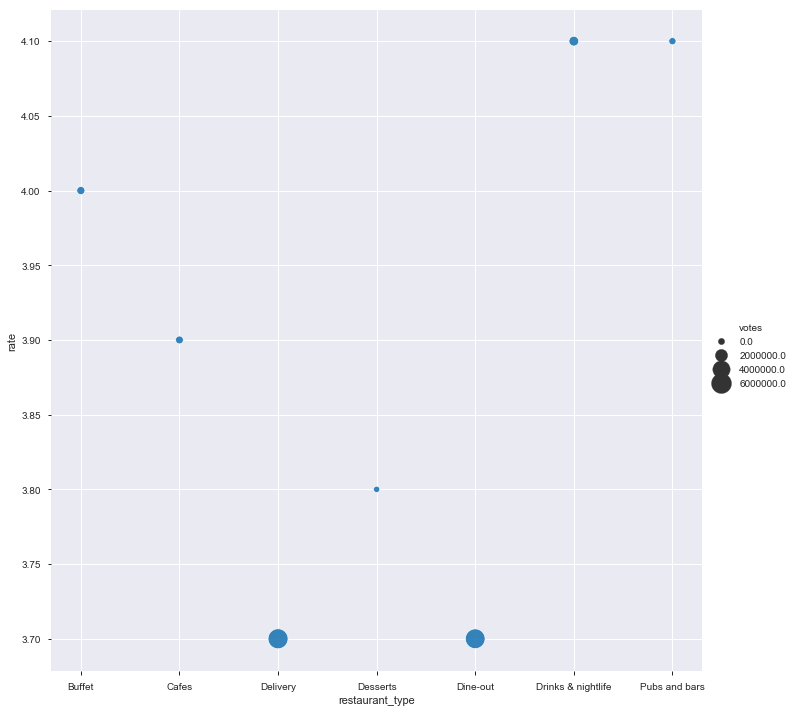

In [209]:
sns.relplot(x="restaurant_type", y="rate", size="votes",
            sizes=(40, 400), alpha=.9, palette="Paired",
            height=10, data=df_by_resttype)

In [210]:
DataFull.columns.values

array(['address', 'rest_name', 'online_order', 'book_table', 'rate',
       'votes', 'location', 'restaurant_category', 'dish_liked',
       'cuisines', 'meal_cost', 'reviews_list', 'menu_item',
       'restaurant_type', 'listed_city'], dtype=object)

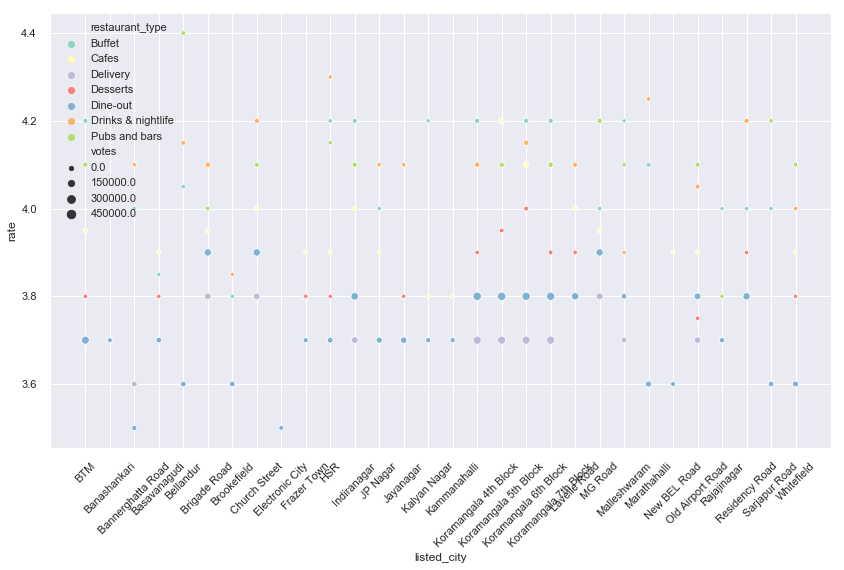

In [211]:
# ### 2 level aggregatios

df_by_locneigh = DataFull.groupby(['listed_city','restaurant_type']).agg({'rate':'median','votes':'sum'}).reset_index()


g = sns.set(rc={'figure.figsize':((14,8))})
g = sns.scatterplot(x="listed_city", y="rate", size="votes", hue='restaurant_type',
                palette='Set3', data=df_by_locneigh[df_by_locneigh['votes']>10000])
plt.xticks(rotation=45)
plt.show()


#data.sort_values('rate',ascending=False)[['name','Cusine','rate']].head(20).drop_duplicates()

#### Rate distribution

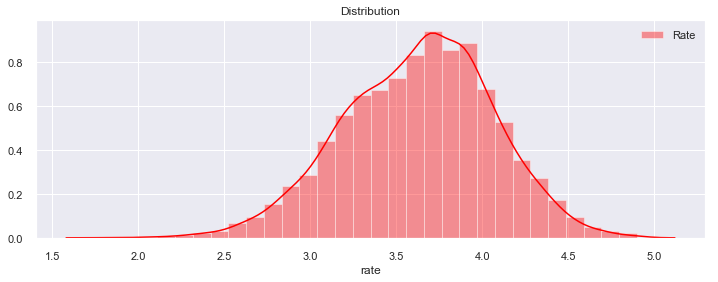

In [212]:
plt.figure(figsize=(12,4))
plt.title("Distribution")
sns.distplot(data['rate'],color="red", kde=True,bins=30, label='Rate')
plt.legend()
plt.show()

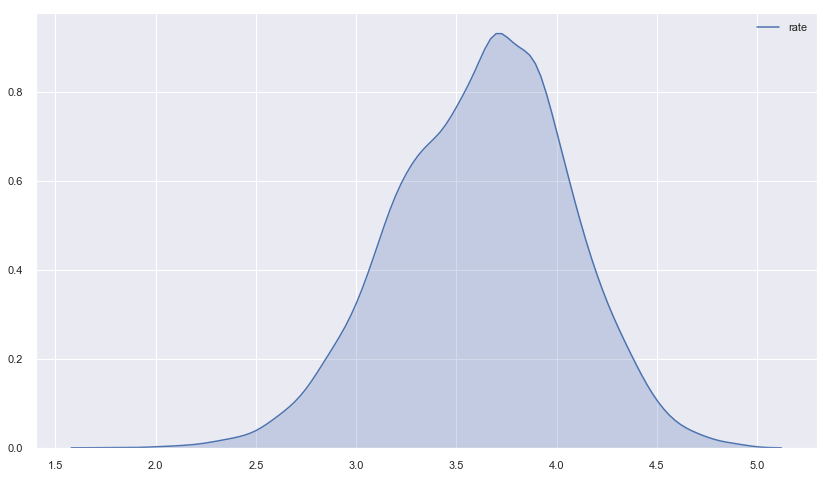

In [213]:
sns.kdeplot(data['rate'], shade=True)

#### Cost of dish

In [214]:
data['meal_cost'].head() # needs preprocessing

0    800.0
1    800.0
2    800.0
3    300.0
4    600.0
Name: meal_cost, dtype: float64

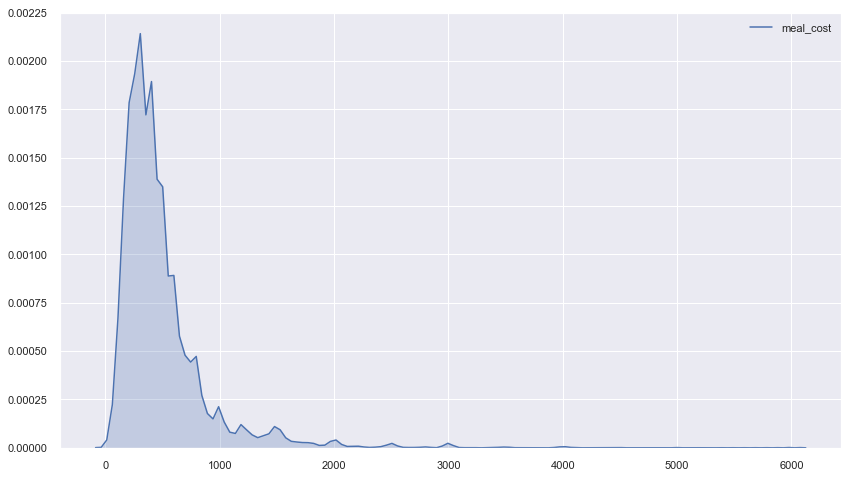

In [215]:
sns.kdeplot(data['meal_cost'], shade=True)

In [216]:
data.meal_cost.describe()

count    12440.00000
mean       487.20000
std        390.85198
min         40.00000
25%        250.00000
50%        400.00000
75%        600.00000
max       6000.00000
Name: meal_cost, dtype: float64

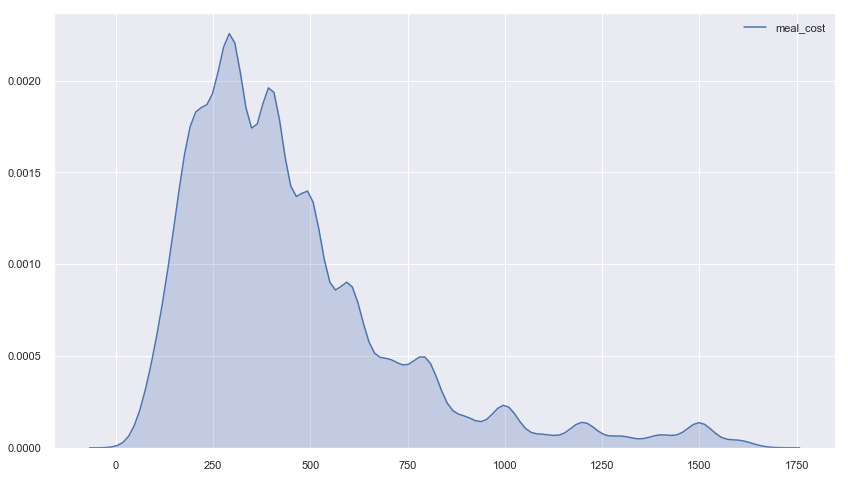

In [217]:
#### Removing abnormalities

# Assuming that this high valueof order is an error

AbnormValue=data.meal_cost.mean()+data.meal_cost.std()*3
final_list = [x for x in data.meal_cost if (x >AbnormValue)]
final_set = set(final_list) 
unique_list = (list(final_set))


data.loc[data.meal_cost.isin(unique_list)] = np.nan


sns.kdeplot(data['meal_cost'], shade=True)


### Geovisualization

In [218]:
locations=pd.DataFrame({"loc":data['location'].unique()})
locations['loc']=locations['loc'].apply(lambda x: "Bangalore " + str(x))
geo_xy=[]
geolocator=Nominatim(user_agent="app")
for location in locations['loc']:
    location = geolocator.geocode(location)
    if location is None:
        geo_xy.append(np.nan)
    else:    
        geo=(location.latitude,location.longitude)
        geo_xy.append(geo)


locations['geo_loc']=geo_xy





# https://github.com/geopy/geopy/issues/171
# https://gis.stackexchange.com/questions/198530/plotting-us-cities-on-a-map-with-matplotlib-and-basemap/198570



In [219]:
locations = locations.dropna().reset_index()
data['location2'] = data['location'].apply(lambda x: "Bangalore " + str(x))
data_agg=data.groupby('location2')['rate'].agg(np.mean)
datageo=pd.merge(data_agg, locations, left_on='location2', right_on='loc', how='inner')
#datageo

In [220]:
asdf = datageo["geo_loc"].tolist()
x, y = zip(*asdf)
#map(x,y,marker='o',color='Red',markersize=row["rate"])
#plt.show()


In [224]:
os.chdir('/Users/gosc/Desktop/Kaggle') 

In [247]:
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
#g=gpd.read_file("Ih_IntroductiontoSpatialAnalysiswithGeopandas/Shp/Guayaqui_Poligonos.shp")
g=gpd.read_file("IND_adm/IND_adm3.shp")

In [251]:
#g

In [252]:
location_p=g['NAME_1'].unique()

In [253]:
location_p

array(['Andaman and Nicobar', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli', 'Daman and Diu', 'Delhi', 'Goa',
       'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir',
       'Jharkhand', 'Karnataka', 'Kerala', 'Lakshadweep',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Orissa', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttaranchal', 'West Bengal'], dtype=object)

In [254]:
g_bangalore = g[(g['NAME_2']== 'Bangalore Rural')| (g['NAME_2']=='Bangalore Urban')]

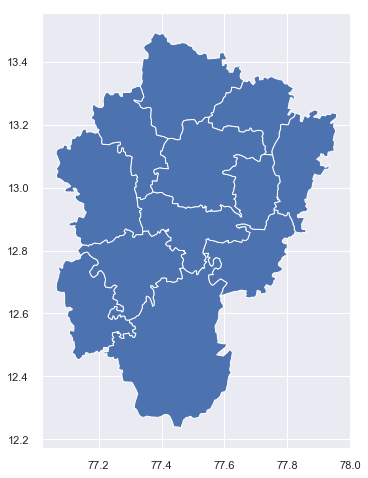

In [255]:
g_bangalore.plot()

In [256]:
g_bangalore2 = g[(g['NAME_3']== 'Bangalore')]

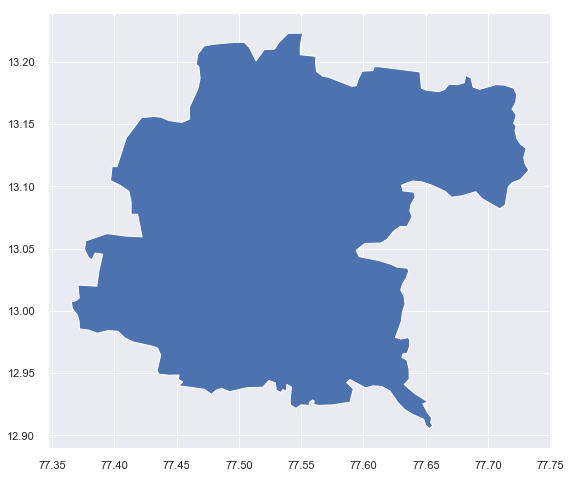

In [257]:
g_bangalore2.plot()

In [223]:
#g=gpd.read_file("karnataka_highway/karnataka_highway.shp")

In [249]:
#g=gpd.read_file("IND_adm/IND_adm3.shp")

In [323]:
geo = datageo["geo_loc"].tolist()
x, y = zip(*geo)
crs = {'init': 'espg:4326'}

In [324]:
geometry=[Point(xy) for xy in zip(geo)]

In [325]:
geo_df=gpd.GeoDataFrame(datageo, crs=crs, geometry=geometry)

In [353]:
cc = gpd.sjoin(g_bangalore, geo_df, how="inner", op='contains')

In [354]:
cc

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry,index_right,rate,index,loc,geo_loc


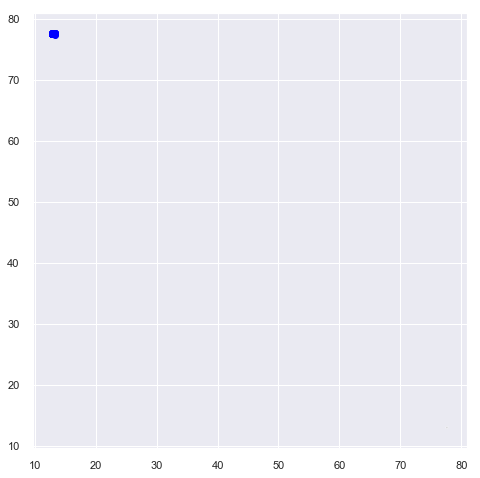

In [327]:
fig, ax = plt.subplots(figsize = (8,8))
g_bangalore2.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax,color="blue")

No handles with labels found to put in legend.


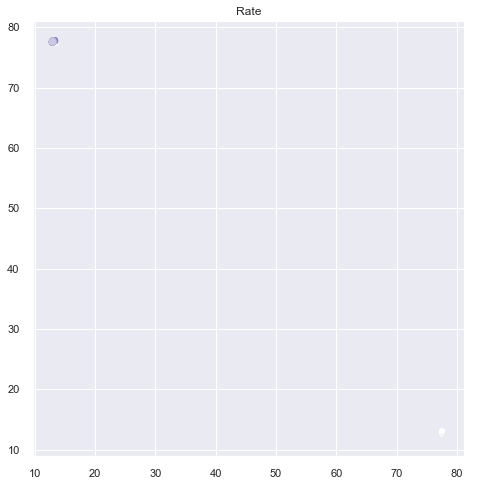

In [313]:
fig, ax = plt.subplots(figsize = (8,8))
g_bangalore.plot(ax=ax)
geo_df.plot(column='rate', ax=ax, cmap = 'Purples')
plt.title('Rate')
plt.legend()

### TEXT PROCESSING

##### DISH LIKED

In [229]:
# Spliting text columns

words_list=[]
for dish in data['dish_liked']:
    dish = str(dish)
    tokens = dish.split()
    for t in tokens:
        t = t.replace(',', '')
        if t != 'nan':
            words_list.append(t)


DishedDF=pd.DataFrame(words_list)
DishedDF[0].value_counts().head(5)

Chicken      2812
Biryani      1602
Pizza         756
Masala        649
Chocolate     617
Name: 0, dtype: int64

##### Menu Item

In [233]:
d=data['menu_item']
menu=[]
for dish in d:
    dish = str(dish)
    dish = dish.replace('\\', '')
    dish = dish.replace('[', '')
    dish = dish.replace(']', '')
    tokens = dish.split("', '")
    for t in tokens:
        t = t.replace(',', '')
        if len(t)>0:
            menu.append(t)


menudf=pd.DataFrame(menu)
menudf[0].value_counts().head(5)

Chicken Fried Rice      752
Veg Fried Rice          739
Paneer Butter Masala    648
Jeera Rice              635
Egg Fried Rice          613
Name: 0, dtype: int64

#### Defining word count/ cloud function

In [230]:
def WordCount(WordsList, limit=30):
    plt.figure(figsize=(10,4))
    sns.countplot(pd.DataFrame(WordsList)[0], 
    palette='Set3',order = pd.DataFrame(WordsList)[0].value_counts().head(limit).index)
    plt.xticks(rotation=90)

def wordCloud(data, backgroundcolor="white", wordmax=80, sizefont=20, color='steelblue'):
    wc = WordCloud(background_color=backgroundcolor, 
                   max_words=wordmax, max_font_size=sizefont, scale=10, contour_color=color)
    wc.generate(' '.join(data))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Dish liked

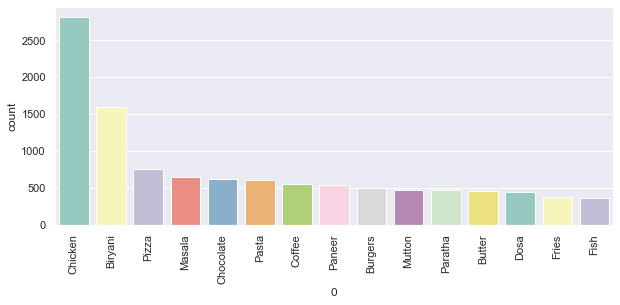

In [231]:
WordCount(words_list, 15)

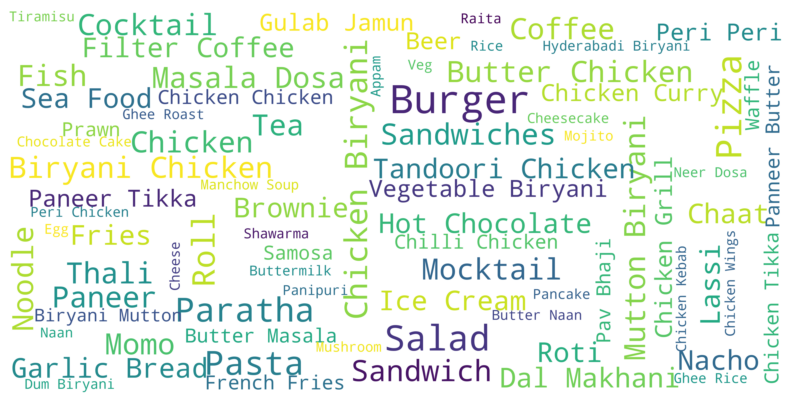

In [232]:
wordCloud(words_list)

#### Menu items

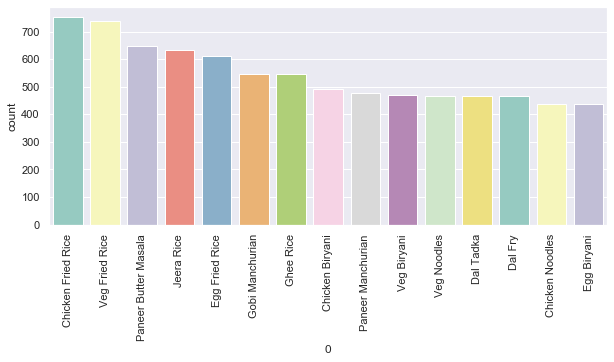

In [236]:
WordCount(menudf, 15)

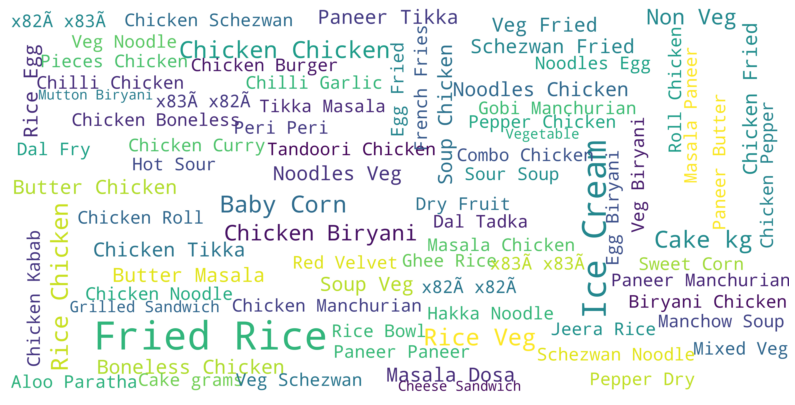

In [238]:
wordCloud(menu)

#### Reviews

In [239]:
data.reviews_list.head(5)

0    [('Rated 4.0', 'RATED\n  A beautiful place to ...
1    [('Rated 4.0', 'RATED\n  Had been here for din...
2    [('Rated 3.0', "RATED\n  Ambience is not that ...
3    [('Rated 4.0', "RATED\n  Great food and proper...
4    [('Rated 4.0', 'RATED\n  Very good restaurant ...
Name: reviews_list, dtype: object

In [241]:
# Splitting columns

reviews=data.reviews_list.copy()
sentences_tokens = []

In [245]:
for i in range(len(reviews[:10])):#first 10
    review = reviews[i]
    review = re.sub(r'\\n|\\x|\.', ' ', review)
    tokens = re.sub("[^a-z ]+", "", review.lower())
    tokens = tokens.split()
    tokens = [w for w in tokens if (w not in set(stopwords.words('english')) and (w!='rated'))]
    sentences_tokens.extend(tokens)
        

len(sentences_tokens)

18378

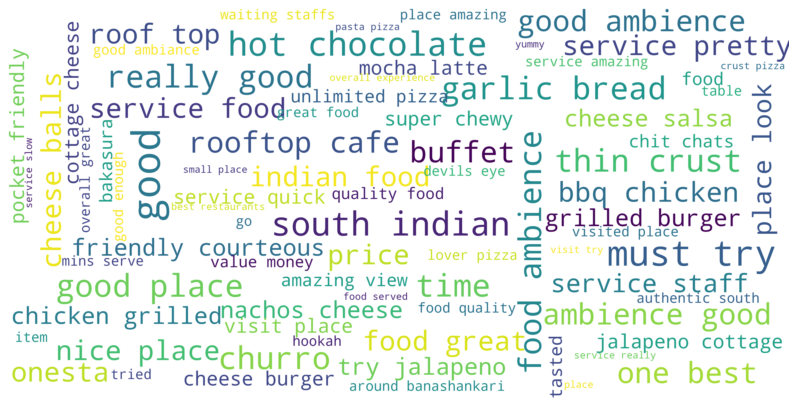

In [246]:
wordCloud(sentences_tokens)

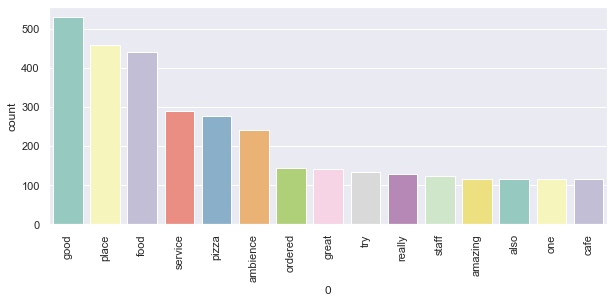

In [247]:
WordCount(sentences_tokens, 15)

### Next steps

#### Bag of word and sentiment analysis